In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Indian_Extent = pd.read_excel(filepath, sheet_name='Indian-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Indian_Extent)
fp.date_time(Indian_Extent)

,Extent,Date
0,376618.799,1979-01-01
1,211788.726,1979-02-01
2,262868.141,1979-03-01
3,698377.304,1979-04-01
4,1252407.727,1979-05-01
...,...,...
533,1520776.003,2023-06-01
534,2076164.165,2023-07-01
535,2731799.027,2023-08-01
536,3179384.692,2023-09-01


In [5]:
scaler = MinMaxScaler()
Indian_Extent['Extent'] = scaler.fit_transform(Indian_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 5
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Indian_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((522, 12, 1), (522,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Indian_model_LT5/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 39s 525ms/step - loss: 0.2421 - root_mean_squared_error: 0.4920 - val_loss: 0.1416 - val_root_mean_squared_error: 0.3763
Epoch 2/50
53/53 [==============================] - 26s 493ms/step - loss: 0.1088 - root_mean_squared_error: 0.3299 - val_loss: 0.0695 - val_root_mean_squared_error: 0.2636
Epoch 3/50
53/53 [==============================] - 26s 508ms/step - loss: 0.0739 - root_mean_squared_error: 0.2718 - val_loss: 0.0536 - val_root_mean_squared_error: 0.2315
Epoch 4/50
53/53 [==============================] - 26s 498ms/step - loss: 0.0553 - root_mean_squared_error: 0.2351 - val_loss: 0.0371 - val_root_mean_squared_error: 0.1926
Epoch 5/50
53/53 [==============================] - 26s 504ms/step - loss: 0.0337 - root_mean_squared_error: 0.1836 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1350
Epoch 6/50
53/53 [==============================] - 27s 514ms/step - loss: 0.0171 - root_mean_squared_error: 0.1308 - val_loss: 0.0117 

53/53 [==============================] - 25s 486ms/step - loss: 0.0054 - root_mean_squared_error: 0.0737 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0501
Epoch 31/50
53/53 [==============================] - 26s 500ms/step - loss: 0.0056 - root_mean_squared_error: 0.0750 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0485
Epoch 32/50
53/53 [==============================] - 3s 64ms/step - loss: 0.0055 - root_mean_squared_error: 0.0743 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0537
Epoch 33/50
53/53 [==============================] - 3s 60ms/step - loss: 0.0050 - root_mean_squared_error: 0.0709 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0526
Epoch 34/50
53/53 [==============================] - 3s 60ms/step - loss: 0.0054 - root_mean_squared_error: 0.0736 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0522
Epoch 35/50
53/53 [==============================] - 3s 63ms/step - loss: 0.0052 - root_mean_squared_error: 0.0723 - val_loss: 0.0030 - val_root_mea

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

12.49625322818756 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

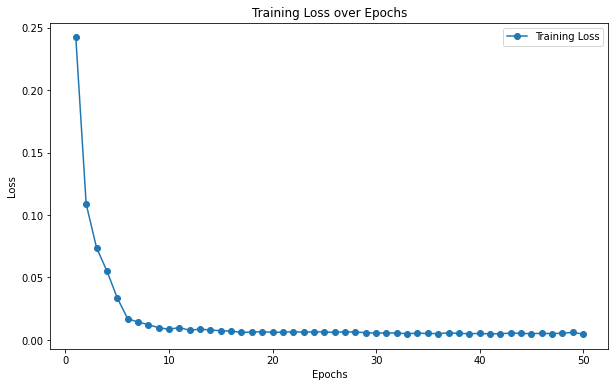

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

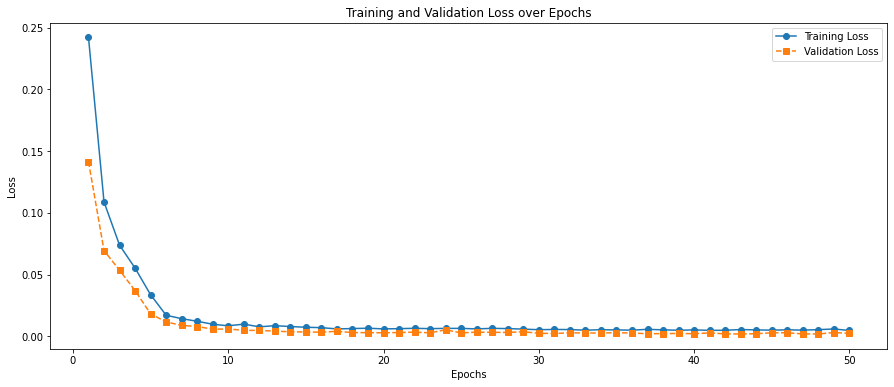

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Indian_model_LT5/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 2s 37ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.06835562351302384
MAE : 0.05605166246863316


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,3.438513e+06,3719188.531
1,3.522857e+06,3636501.241
2,3.113164e+06,2526913.818
3,1.769317e+06,1128752.378
4,3.391069e+05,522831.371
5,1.194867e+05,346601.304
6,2.183767e+05,444914.605
7,5.771875e+05,827036.916
8,1.154466e+06,1142021.216
9,1.806749e+06,1885693.654


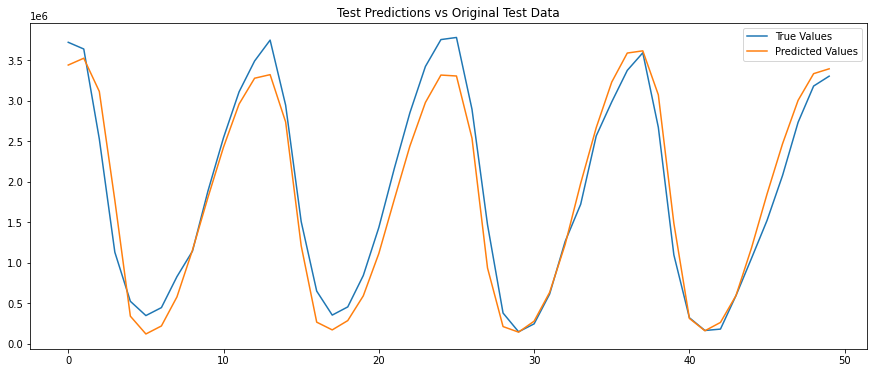

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 1s 35ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

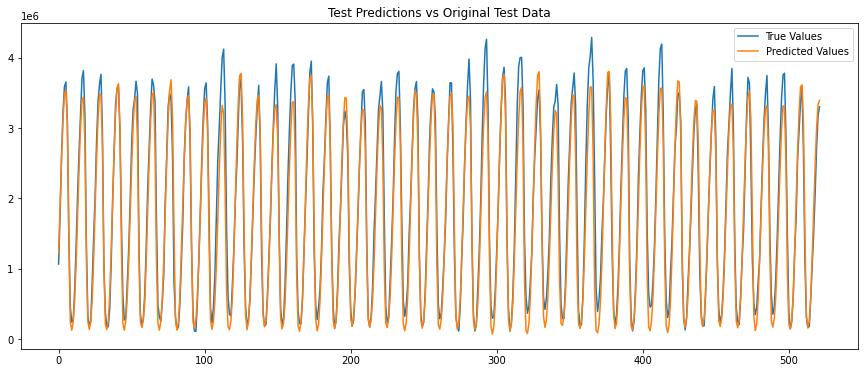

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()